### Introduction
Since the §RAM55 IRM is symmetric, there are $136$ unique $3{\times}3$ sub-matrices.  For each of these we computed the Pearson's $\chi^2$ statistic and $p$-value (after Bonferroni correction) for the hypothesis test of independence of the observed $\chi_{1}$ rotamer configuration change frequencies, where the expected frequencies are computed based on the marginal sums under the assumption of independence. 

Pairs of residues with Bonferroni $p$-value $< 0.05$ are showing significant association among their rotamer states; only these are considered for further analysis (e.g.~Fig.~\ref{fig:Cramer_sV_diagratio}). Overall, 111 of the 136 independent $3{\times}3$ sub-matrices show significant association among the interchanging states.
To further quantify the strength of these sub-matrix exchange patterns we use Cram\'er's V (also written as $\widetilde{V}$) with bias correction \cite{Bergsma2013}, a measure of association between two categorical variables (here the $\chi_{1}$ configurations of amino acids $A$ and $A'$). 

Existence of strong association does not guarantee a diagonal pattern (rotamer configuration conservation); we therefore also consider the diagonal ratio for each sub-matrix, indicating the proportion of rates that lie on each $3{\times}3$ sub-matrix's diagonal. 

### Imports

In [1]:
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sb
import itertools
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sb

plt.style.use(['seaborn-white', 'seaborn-paper'])
matplotlib.rc("font", serif="Helvetica Neue")

current_palette = sb.color_palette("colorblind", 6, desat=.9)

### Analysis

/anaconda3/envs/py3.5/lib/python3.5/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/py3.5/lib/python3.5/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/py3.5/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

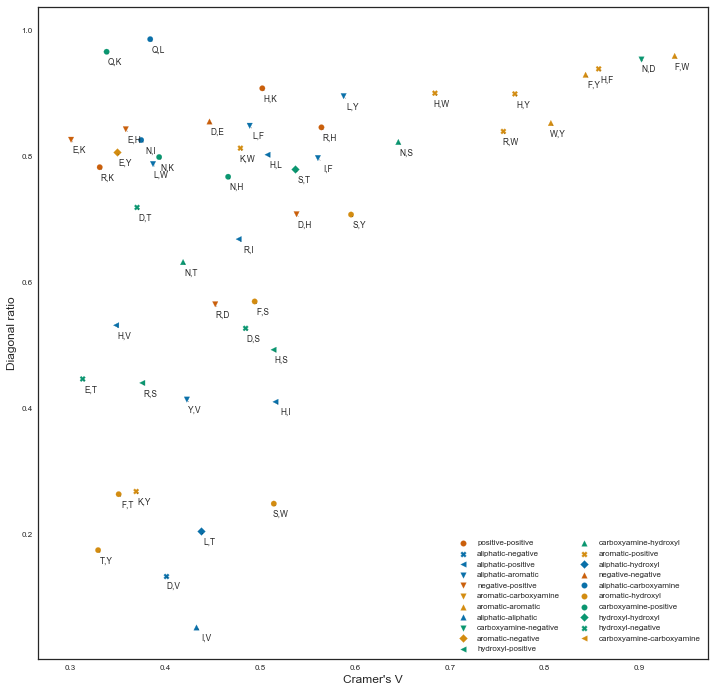

In [6]:
data = pd.read_csv("data/rotamers_adj_shared_count_matrix.merged.Dayhoff_norm.block_association",
                   sep="\t", header=None, index_col=None, names=["l1", "l2", "CramersV", 
                                                                 "TschuprowsT", "diagonal_ratio"]).dropna()


# drop non-3x3 AA and all of those not in a first level group
to_drop = ["ALA", "GLY", "PRO", "CYS", "MET"]
square_data = data.query('l1 not in @to_drop & l2 not in @to_drop')

# drop Cramer's V = 0
nozero_data = square_data.query('CramersV > 0.3')

# assign AA to groups, HIS is classified as positive
AAdict = {'GLN': 'carboxyamine', 'HIS': 'positive', 'SER': 'hydroxyl',
          'VAL': 'aliphatic', 'LYS': 'positive', 'ILE': 'aliphatic', 'ASN': 'carboxyamine',
          'THR': 'hydroxyl', 'PHE': 'aromatic', 'ASP': 'negative', 'LEU': 'aliphatic', 'ARG': 'positive',
          'TRP': 'aromatic', 'GLU': 'negative', 'TYR': 'aromatic'
          }

# one marker per AA1 - AA2 combination
colors = sb.color_palette("colorblind", 6, desat=.9)
l = list(itertools.combinations_with_replacement(
    sorted(set(AAdict.values())), 2))
s = list(itertools.product(colors, ["^", "v", "o", "D", "X", "<"]))

sym_dict = dict(zip(l, s))


def map_or_reversemap(g_tup):
    if g_tup in sym_dict:
        return sym_dict[g_tup]
    else:
        inv_tup = (g_tup[1], g_tup[0])
        return sym_dict[inv_tup]


L = list(zip(nozero_data['l1'].map(AAdict).astype(
    str), nozero_data['l2'].map(AAdict).astype(str)))

nozero_data["symbol"] = [map_or_reversemap(l) for l in L]
nozero_data["type"] = L

# convert AA names to one letter codes
three_one_dict = dict(zip("ALA,ARG,ASN,ASP,CYS,GLN,GLU,GLY,HIS,ILE,LEU,LYS,\
                          MET,PHE,PRO,SER,THR,TRP,TYR,VAL".split(","),
                          "A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V".split(",")))
nozero_data.loc[:, "sl1"] = nozero_data['l1'].map(three_one_dict)
nozero_data.loc[:, "sl2"] = nozero_data['l2'].map(three_one_dict)

plt.clf()
fig, ax = plt.subplots(figsize=(12, 12))

groups = nozero_data.groupby("symbol")

patches = []
patch_labels = []


for key, value in sym_dict.items():
    patches.append(plt.scatter([], [], marker=value[1], color=value[0]))
    patch_labels.append("-".join(key))


for name, group in groups:
    # marker patches for AA2's group
    c, m = name
    group.plot.scatter(x='CramersV', y='diagonal_ratio', c=[c]*group.shape[0],
                       marker=m, s=30, ax=ax)

    for label, x_val, y_val in zip(group["sl1"] + "," + group["sl2"],
                                   group['CramersV'].tolist(), group['diagonal_ratio'].tolist()):
        plt.annotate(label, xy=(x_val, y_val), xytext=(15, -15), textcoords='offset points',
                     ha='right', va='bottom', fontsize='small', arrowprops=dict(arrowstyle='-',
                                                                                connectionstyle='arc3,rad=0'))


ax.set_xlabel('Cramer\'s V', fontsize='large')
ax.set_ylabel('Diagonal ratio', fontsize='large')
plt.legend(patches, patch_labels, ncol=2, loc='lower right')

plt.show()
fig.savefig('Figures/CramerV_diagratio.scatter.UNIFORM.svg',
            format='svg', bbox_inches='tight', dpi=fig.dpi)

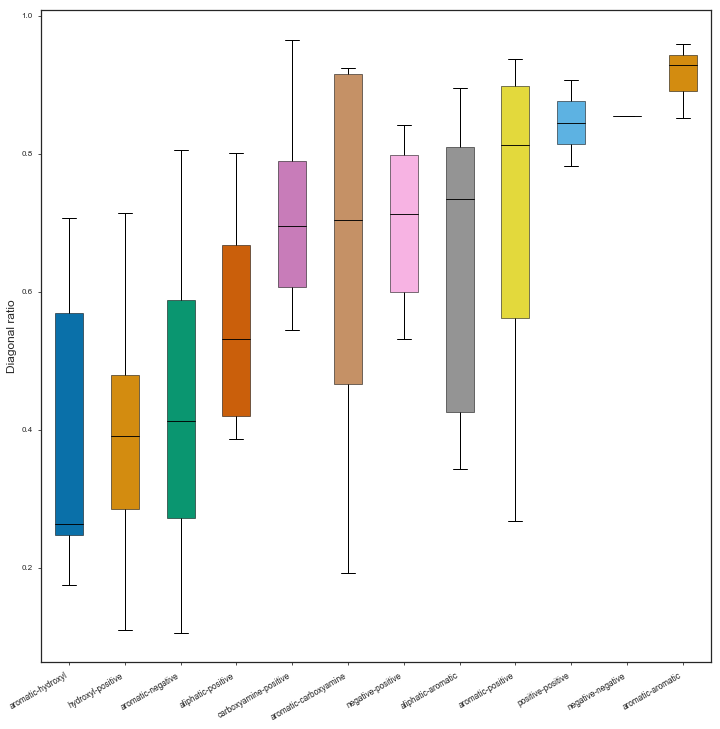

In [112]:
data = pd.read_csv("data/rotamers_adj_shared_count_matrix.merged.Dayhoff_norm.block_association",
                   sep="\t", header=None, index_col=None, names=["l1", "l2", "CramersV",
                                                                 "TschuprowsT", "diagonal_ratio"]).dropna()


# drop non-3x3 AA and all of those not in a first level group
to_drop = ["ALA", "GLY", "PRO", "CYS", "MET"]
square_data = data.query('l1 not in @to_drop & l2 not in @to_drop')

# drop Cramer's V = 0
nozero_data = square_data.query('CramersV > 0.0')

# assign AA to groups, HIS is classified as positive
AAdict = {'GLN': 'carboxyamine', 'HIS': 'positive', 'SER': 'hydroxyl',
          'VAL': 'aliphatic', 'LYS': 'positive', 'ILE': 'aliphatic', 'ASN': 'carboxyamine',
          'THR': 'hydroxyl', 'PHE': 'aromatic', 'ALA': 'hydrophobic', 'ASP': 'negative',
          'LEU': 'aliphatic', 'ARG': 'positive', 'TRP': 'aromatic', 'GLU': 'negative',
          'TYR': 'aromatic'
          }

# one color per AA1 - AA2 combination
unique_groups = list(itertools.combinations_with_replacement(
    sorted(set(AAdict.values())), 2))


def map_or_reversemap(g_tup):
    if g_tup in unique_groups:
        return "-".join(g_tup)
    else:
        inv_tup = (g_tup[1], g_tup[0])
        return "-".join(inv_tup)


nozero_data.loc[:, "group_name"] = np.vectorize(map_or_reversemap)(pd.Series(zip(
    nozero_data['l1'].map(AAdict).astype(str), nozero_data['l2'].map(AAdict).astype(str))))

to_keep = ['aromatic-aromatic', 'negative-negative', 'positive-positive',
           'aromatic-positive', 'aliphatic-aromatic',
           'negative-positive', 'aromatic-carboxyamine', 'carboxyamine-positive',
           'aliphatic-positive', 'aromatic-negative',
           'hydroxyl-positive', 'aromatic-hydroxyl']

nozero_data = nozero_data.query('group_name in @to_keep')

# convert AA names to one letter codes
three_one_dict = dict(zip("ALA,ARG,ASN,ASP,CYS,GLN,GLU,GLY,HIS,ILE,LEU,LYS,\
MET,PHE,PRO,SER,THR,TRP,TYR,VAL".split(","),
                          "A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V".split(",")))
nozero_data.loc[:, "sl1"] = nozero_data['l1'].map(three_one_dict)
nozero_data.loc[:, "sl2"] = nozero_data['l2'].map(three_one_dict)

plt.clf()
fig, ax = plt.subplots(figsize=(12, 12))

nozero_data.loc[:, 'group_median'] = nozero_data.groupby(
    'group_name')['diagonal_ratio'].transform(np.median)
nozero_data.sort_values(['group_median'], ascending=[True], inplace=True)
# remove small groups
groups = nozero_data.groupby('group_name', sort=False)
groups = groups.filter(lambda x: len(x) > 0).groupby('group_name', sort=False)

y = []
l = []
for name, group in groups:
    y.append(group.loc[:, 'diagonal_ratio'].values)
    l.append(name)
np.array(y)

colors = sb.color_palette("colorblind", len(l), desat=.9)

bp = ax.boxplot(y, patch_artist=True, widths=.5, positions=range(len(l)))
for box, c in zip(bp['boxes'], colors):
    # change outline color
    box.set(color='#000000', linewidth=0.5)
    # change fill color
    box.set(facecolor=c)
for median in bp['medians']:
    median.set(color='k', linewidth=0.9)
# change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='', color=c)

plt.style.use(['seaborn-white', 'seaborn-paper'])
matplotlib.rc("font", serif="Helvetica Neue")
ax.set_ylabel('Diagonal ratio', fontsize='large')
ax.tick_params(axis='both', length=3)
ax.set_xticks(range(len(l)))
ax.set_xticklabels(l, rotation=30, fontsize='small', ha='right')
plt.show()
fig.savefig('Figures/CramersV_diagratio.boxplots.svg',
            format='svg', bbox_inches='tight', dpi=fig.dpi)